# SQLAlchemy Climate Analysis and Exploration

## Set up and Import Dependencies

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

## Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
# -------------------------------------------------
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
# -------------------------------------------------
Base = automap_base()

# reflect the tables
# -------------------------------------------------
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
# -------------------------------------------------
Base.classes.keys()

['measurement', 'station']

In [8]:
# Print a list of column names and types per table
# -------------------------------------------------
inspector = inspect(engine)

columns = inspector.get_columns('measurement')
print (f'Measurement table\n---------------------')
for c in columns:
    print(c['name'], c["type"])
print (f'---------------------')

columns = inspector.get_columns('station')
print (f'Station table\n---------------------')
for c in columns:
    print(c['name'], c["type"])
print (f'---------------------')

Measurement table
---------------------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
---------------------
Station table
---------------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
---------------------


In [9]:
# Save references to each table
# -------------------------------------------------
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
# -------------------------------------------------
session = Session(engine)

In [11]:
engine.execute('SELECT * FROM Measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [12]:
engine.execute('SELECT * FROM Station LIMIT 10').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

## Precipitation Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# -------------------------------------------------

# Earliest Date
# -------------------------------------------------
earliest_date = session.query(Measurement.date).order_by(Measurement.date).first()
print(f'Earliest date in database is: {earliest_date}')

# Latest Date
# -------------------------------------------------
lastest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f'Latest date in database is: {lastest_date}')

Earliest date in database is: ('2010-01-01',)
Latest date in database is: ('2017-08-23',)


In [14]:
# Calculate the date 1 year ago from the last data point in the database
# -------------------------------------------------
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(f'Date 1 year ago from the last data point in the database is: {one_year_ago}')

Date 1 year ago from the last data point in the database is: 2016-08-23


In [15]:
# Perform a query to retrieve the data and precipitation scores
# -------------------------------------------------
precip_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all() 

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# -------------------------------------------------
precip_df = pd.DataFrame(precip_data)
precip_df.sort_values(by='date')
precip_df = precip_df.set_index('date')

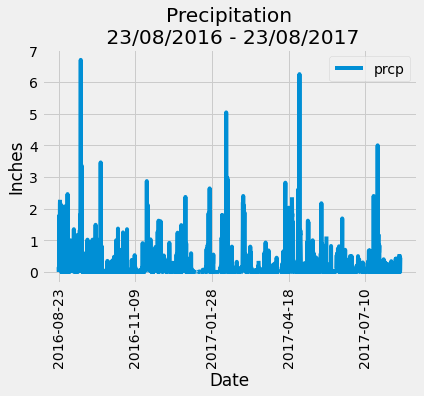

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
# -------------------------------------------------
precip_df.plot()
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title("Precipitation\n 23/08/2016 - 23/08/2017")
plt.xticks(rotation=90)
plt.savefig("images/Precipitation_BarGraph.png", dpi=300,bbox_inches='tight')
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
# -------------------------------------------------
precip_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [19]:
# Design a query to show how many stations are available in this dataset?
# -------------------------------------------------
station_count = session.query(Station.station).group_by(Station.station).count()
print(f"There are {station_count} stations available in this dataset")

There are 9 stations available in this dataset


In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
#List the stations and the counts in descending order.
# -------------------------------------------------
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
# -------------------------------------------------
most_active = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
            filter(Measurement.station == 'USC00519281').all()
print(f"The Minimum temperature is {most_active[0][0]},\nThe Maximum temperature is {most_active[0][1]}, \nThe Average temperature is {most_active[0][2]}")

The Minimum temperature is 54.0,
The Maximum temperature is 85.0, 
The Average temperature is 71.66378066378067


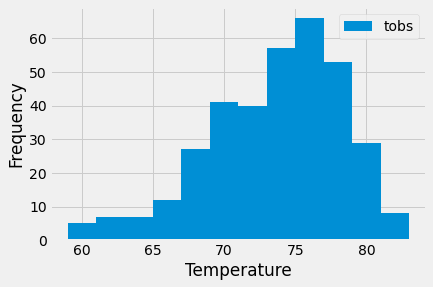

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# -------------------------------------------------
results = session.query(Measurement.tobs).filter(Measurement.date >= one_year_ago).\
            filter(Measurement.station == 'USC00519281').all()

df= pd.DataFrame(results)

df.plot.hist(bins=12)
plt.xlabel('Temperature')
plt.savefig("images/MostActiveStn_Temp_Histogram.png", dpi=300,bbox_inches='tight')
plt.show()